# Part 01: Preprocessing HLS and Land Use Data for Finetuning

## Introduction

This section of the training materials focus on preprocessing HLS images and the corresponding LandUse data to be used for FINETUNING, this step can be skipped if the focus is only on model inference (e.g. using the pretrained model with minimal modifications).

Sample data is located in ./training_materials/data/01_preprocessing.

Listed below are the specific preprocessing steps included in this notebook.

1. Create Cloud Mask for HLS images
2. Convert to WGS84
3. Stack three 6-band HLS images into one 18-band image
4. Crop HLS image using Land Use extents
5. Split HLS image into 224x224 pixels
6. Get matching LU image per 224x224 patch/tile

IMPORTANT:
1. The sample data used for this part is Muang-Udon, Thailand. For larger regions which spans multiple HLS images, regional mosaic should be created first before proceeding with the data preprocessing.
2. Ensure that the LandUse data and the HLS images has the same CRS.

## Visualizing Sample LU data

The Muang-Udon sample raster dataset has 6 land use classes with the corresponding raster values and color code shown below:

| Land Use | Raster Value | Color Code |
|----------|----|----|
| Urban | 1 | red |
| Agricultural | 2 | yellow |
| Forest | 3 | green |
| Water | 4 | blue |
| Oil Palm | 5 | purple |
| Para Rubber | 6 | pink |

IMPORTANT: Gaps in the Land use are due to the removal of Mixed/Miscellaneous classes (example: Golf Course, Garbage Dump)

Raster CRS: EPSG:4326


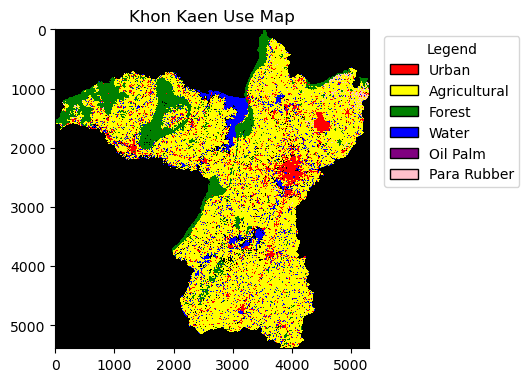

CPU times: user 341 ms, sys: 117 ms, total: 458 ms
Wall time: 460 ms


In [57]:
%%time
## Visualizing sample Muang-Udon Land Use data
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# os is for handling paths, files, and folders
# rasterio is used for handling raster data in python
# numpy is used to manipulate matrix-like datasets similar to a raster dataset
# matplotlib is used to visualize the raster data / plot charts, etc.

# Step 1: read the raster file
#raster_path = '../data/01_preprocessing/muang_udon_lu_raster/LU_muang-udon.tif' #change the raster path based on where you stored the raster file
raster_path = '../data/01_preprocessing/muang_udon_lu_raster/khon-kaen.tif'

with rio.open(raster_path) as src:
    raster_data = src.read(1) #read just the 1st band
    crs = src.crs
     
print("Raster CRS:",crs) #check the coordinate reference system of the raster file
    
# Step 2: define the colormap
# Colors are assigned based on value / Landuse type
value_to_color = {
    1:'red',
    2:'yellow',
    3:'green',
    4:'blue',
    5:'purple',
    6:'pink'}

# create a colormap with these values
colors = [value_to_color.get(i,'black') for i in range(0,max(value_to_color.keys()) + 1)]
cmap = ListedColormap(colors)

# Step 3: Display the raster with the colormap
plt.figure(figsize=(6,6))
plt.title("Khon Kaen Use Map")
plt.imshow(raster_data,cmap=cmap,interpolation='none')

# Step 4: Add legend
# define the raster value and corresponding land use type
lu_legend = {1:'Urban',
             2:'Agricultural',
             3:'Forest',
             4:'Water',
             5:'Oil Palm',
             6:'Para Rubber'}

legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                   for value, color in value_to_color.items()]
plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.5, 1))

# show the plot
plt.tight_layout()
plt.show()

## Preprocessing HLS Data

### Step 0: Creating an 'output' folder to store all outputs from this script

In [2]:
import os

# check if the folder exists --> if not, create the folder.
if not os.path.exists('output'):
    os.makedirs('output')
    print("'output' folder CREATED successfully.")
else:
    print("'output' folder ALREADY EXISTS.")

'output' folder CREATED successfully.


### Step 1: Creating a cloud-free 18-band image stack

#### 1.1 Fmask Reference Table

The full details on how to use the Fmask layer to mask clouds in HLS data is available in the [HLS User Guide V2](https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf) page 17.

The Fmask integer values are converted to the bit representation, as shown in the table below:
| Bit number | Mask name | Bit value | Mask description |
|-----|--------|-----|--------|
| 7-6 | aerosol level | 11 | High aerosol |
| 7-6 | aerosol level | 10 | Moderate aerosol |
| 7-6 | aerosol level | 01 | Low aerosol |
| 7-6 | aerosol level | 00 | Climatology aerosol |
| 5 | Water | 1 | Yes |
| 5 | Water | 0 | No |
| 4 | Snow/ice | 1 | Yes |
| 4 | Snow/ice | 0 | No |
| 3 | Cloud shadow | 1 | Yes |
| 3 | Cloud shadow | 0 | No |
| 2 | Adjacent to cloud/shadow | 1 | Yes |
| 2 | Adjacent to cloud/shadow | 0 | No |
| 1 | Cloud | 1 | Yes |
| 1 | Cloud | 0 | No |
| 0 | Cirrus Reserved, but not used | NA |


#### 1.2 Visualizing cloud mask layer for sample Muang-Udon HLS data

Folder/Date: 2018-02-26
HLS.S30.T48QTE.2018057T033709.v2.0.Fmask.tif


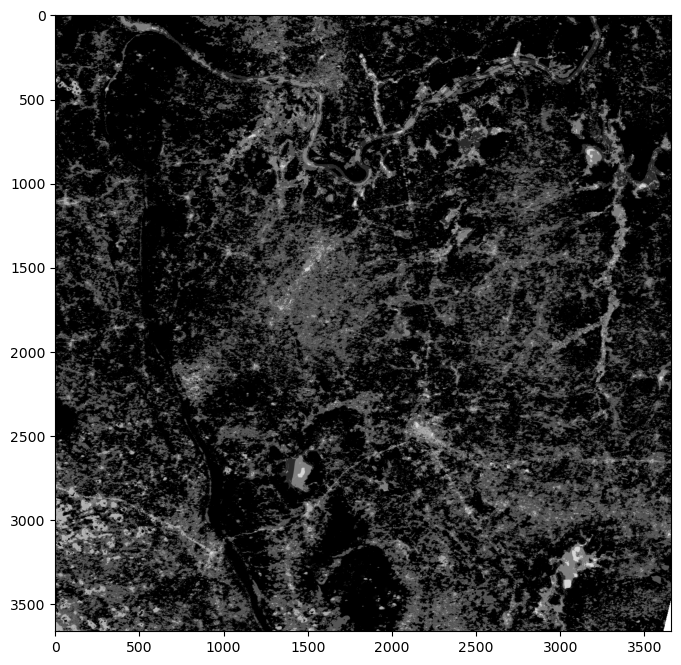

Folder/Date: 2018-10-04
HLS.S30.T48QTE.2018277T033559.v2.0.Fmask.tif


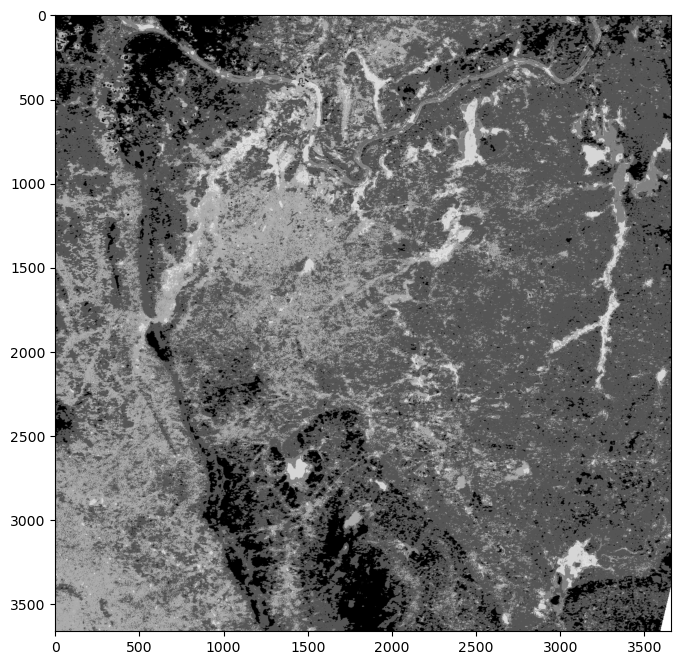

Folder/Date: 2018-11-03
HLS.S30.T48QTE.2018307T033909.v2.0.Fmask.tif


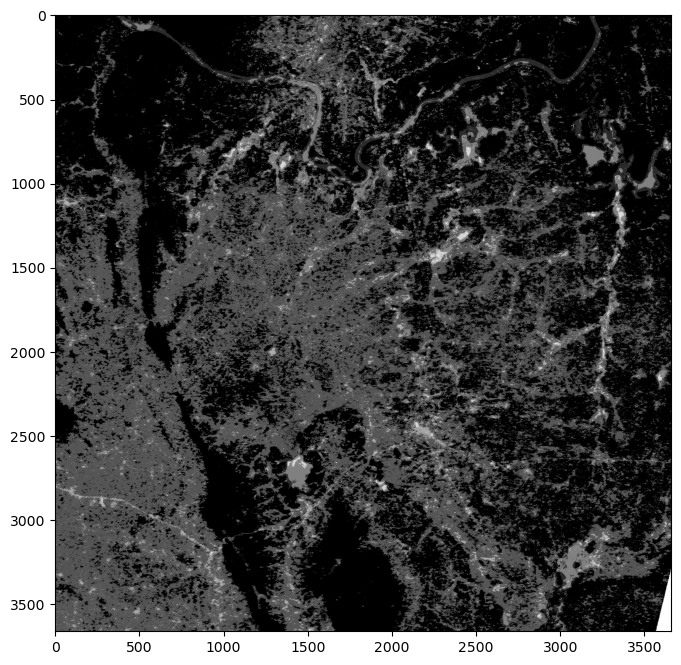

CPU times: user 2.35 s, sys: 150 ms, total: 2.5 s
Wall time: 3.34 s


In [3]:
%%time
# --- THIS SECTION USES THE SAME MODULES/PACKAGES AS THE CELL ABOVE ---
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# read the folders with the HLS files
hls_path = '../data/01_preprocessing/muang_udon_hls' #change the path to the HLS images

# IMPORTANT: there are 3 sets of HLS images inside the folder, as the Prithvi model for multi-temporal crop classification requires 3 time-periods/observations
hls_date_folders = [folder for folder in os.listdir(hls_path)
                    if os.path.isdir(os.path.join(hls_path, folder))
                    and folder != '.ipynb_checkpoints']
# '.ipynb_checkpoints' has to be removed from the list of HLS images since it is being created automatically
# print(hls_date_folders) --> uncomment to show what are the folder names in the list

for hls_folder in hls_date_folders:
    print("Folder/Date:", hls_folder)
    
    fmask_fname = [fname for fname in os.listdir(os.path.join(hls_path,hls_folder)) if 'Fmask' in fname][0]
    print(fmask_fname)
    
    fmask_path = os.path.join(os.path.join(hls_path,hls_folder),fmask_fname)
    
    with rio.open(fmask_path) as src:
        fmask_data = src.read(1)
        plt.figure(figsize=(8,8))
        plt.imshow(fmask_data,cmap='gray')
        plt.show()

#### 1.3 Creating and Applying cloudmask from Fmask layer

The values in the 'cloud_val_list' are the corresponding integer values that should be removed from the Fmask layer.

The table below shows the integer value, the corresponding binary value, and the description from the Fmask reference table

| Integer value | Binary value | Description |
|-----|----------|----------------|
| 194 | 11000010 | High aerosol, Cloud |
| 130 | 10000010 | Moderate aerosol, Cloud |
| 66 | 01000010 | Low aerosol, Cloud |
| 200 | 11001000 | High aerosol, Cloud shadow |
| 136 | 10001000 | Moderate aerosol, Cloud shadow |
| 72 | 01001000 | Low aerosol, Cloud shadow |

Folder CREATED successfully.

Folder/Date: 2018-02-26
HLS.S30.T48QTE.2018057T033709.v2.0.Fmask.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_epsg(32648), 'transform': Affine(30.0, 0.0, 199980.0,
       0.0, -30.0, 2000040.0)}


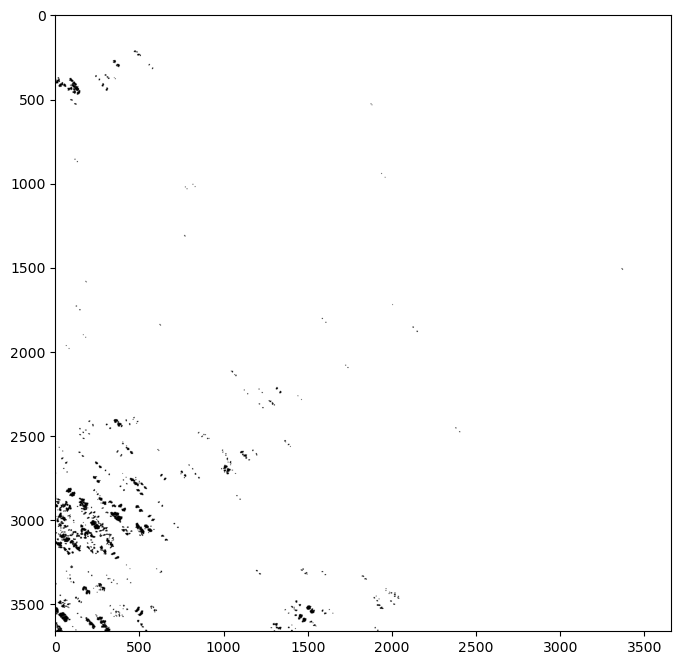

Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.SAA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.SZA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.VZA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.VAA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B01.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B09.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B10.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B12.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B05.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B8A.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B08.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B11.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B03.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B07.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018057T033709.v2.0.B02.tif
Applying C

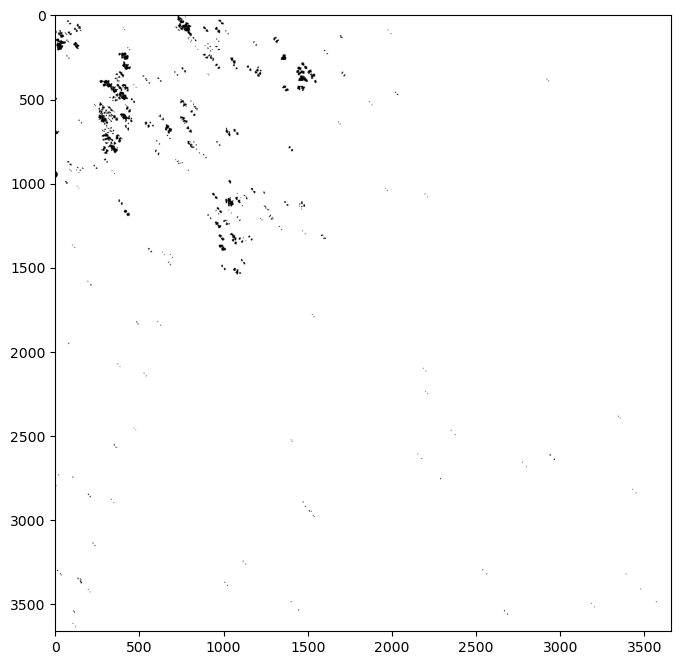

Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.SZA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B09.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.SAA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.VZA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.VAA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B01.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B10.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B04.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B03.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B8A.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B05.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B08.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B02.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B11.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018277T033559.v2.0.B12.tif
Applying C

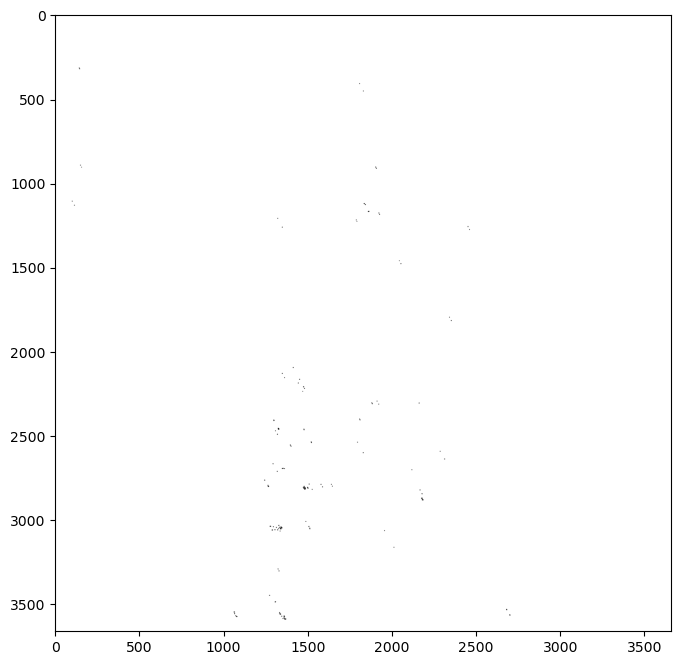

Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.SAA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.SZA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.VZA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.VAA.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B01.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B10.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B09.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B02.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B06.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B04.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B05.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B11.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B07.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B12.tif
Applying Cloud Mask to HLS.S30.T48QTE.2018307T033909.v2.0.B03.tif
Applying C

In [4]:
%%time
# ESTIMATED RUNTIME: 1 minute

#NOTE: the functions in this cell output a raster file for every step of the process, this is done so there is a "checkpoint" for every step
# and the outputs for each process can be reviewed

# --- THESE MODULES ARE USED BY THE CELLS ABOVE, COMMENT OUT IF NOT NECESSSARY TO IMPORT AGAIN ---
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# additional modules for this specific cell
from rasterio.mask import mask

# functions for cloud masking
def create_cloud_mask(fmask_path,
                      exp_path,
                      cloud_val_list=[194,130,66,200,136,72] #refer to the table above for reference
                     ):
    
    with rio.open(fmask_path) as src:
        meta = src.meta.copy()
        ds_fmask = src.read(1)
        print(meta)
        cloud_mask = np.where(np.isin(ds_fmask, cloud_val_list),0,1)

    with rio.open(exp_path, 'w', **meta) as dest:
        dest.write(cloud_mask,1)


def apply_cloud_mask(img_path,
                     fmask_path,
                     exp_path):

    # read image source
    with rio.open(img_path) as img_src:
        # read img as 3D array (bands, height, width)
        img_data = img_src.read()
        profile = img_src.profile
    
    # read cloud mask
    with rio.open(fmask_path) as fmask_src:
        # read mask as 2D array (height, width)
        cloud_mask = fmask_src.read(1)
    
    # check if cloud mask has the same size as image
    if (cloud_mask.shape != (img_data.shape[1], img_data.shape[2])):
        raise ValueError("The cloud mask and the image dimensions do not match.")
    
    # apply the cloud mask to each band
    # mask is binary: 1 (clear) and 0 (clouds)
    masked_data = img_data * cloud_mask
    
    # save the masked image to a new file
    with rio.open(exp_path, 'w', **profile) as dst:
        dst.write(masked_data)
        
        
####### actual run of the cloudmasking functions ########

# NOTE: the 'hls_path' and 'hls_date_folders' are also used in the previous cell, comment out if not necessary

# step 1: read the folders with the HLS files
hls_path = '../data/01_preprocessing/muang_udon_hls' #change the path to the HLS images

hls_date_folders = [folder for folder in os.listdir(hls_path)
                    if os.path.isdir(os.path.join(hls_path, folder))
                    and folder != '.ipynb_checkpoints']


# step 2: create a new folder under 'output' to save the cloud mask outputs
cmask_outpath = 'output/cloudmask'

if not os.path.exists(cmask_outpath):
    os.makedirs(cmask_outpath)
    print("Folder CREATED successfully.")
else:
    print("Folder ALREADY EXISTS.")

# step 3: iterate over the 3 time periods/observations
for hls_folder in hls_date_folders:
    print("\nFolder/Date:", hls_folder)
      
    # step 3.1: create the date folder inside the 'output/01_cloudmask' folder
    if os.path.exists(os.path.join(cmask_outpath,hls_folder)):
        pass
    else:
        os.makedirs(os.path.join(cmask_outpath,hls_folder))
        
    # step 3.2: read the fmask file
    fmask_fname = [fname for fname in os.listdir(os.path.join(hls_path,hls_folder)) if 'Fmask' in fname][0]
    print(fmask_fname)
    
    # step 3.3: define the fmask and cmask (cloud mask) paths
    fmask_path = os.path.join(os.path.join(hls_path,hls_folder),fmask_fname)
    cmask_path = os.path.join(os.path.join(cmask_outpath,hls_folder),fmask_fname.replace('Fmask','Cmask'))
    
    # step 3.4: create cloudmask file
    create_cloud_mask(fmask_path,cmask_path)
    
    # show the cloudmask
    with rio.open(cmask_path) as src:
        fmask_data = src.read(1)
        plt.figure(figsize=(8,8))
        plt.imshow(fmask_data,cmap='gray')
        plt.show()
        
    # step 3.5: apply cloud mask
    for fname in os.listdir(os.path.join(hls_path,hls_folder)):
        if fname == '.ipynb_checkpoints' or 'Fmask' in fname:
            continue
        
        print("Applying Cloud Mask to {}".format(fname))
        apply_cloud_mask(os.path.join(os.path.join(hls_path,hls_folder),fname),
                         cmask_path,
                         os.path.join(os.path.join(cmask_outpath,hls_folder),fname))

#### 1.4 Stacking into 18-band HLS images

['output/cloudmask/2018-02-26/HLS.S30.T48QTE.2018057T033709.v2.0.B02.tif', 'output/cloudmask/2018-02-26/HLS.S30.T48QTE.2018057T033709.v2.0.B03.tif', 'output/cloudmask/2018-02-26/HLS.S30.T48QTE.2018057T033709.v2.0.B04.tif', 'output/cloudmask/2018-02-26/HLS.S30.T48QTE.2018057T033709.v2.0.B8A.tif', 'output/cloudmask/2018-02-26/HLS.S30.T48QTE.2018057T033709.v2.0.B11.tif', 'output/cloudmask/2018-02-26/HLS.S30.T48QTE.2018057T033709.v2.0.B12.tif']
['output/cloudmask/2018-10-04/HLS.S30.T48QTE.2018277T033559.v2.0.B02.tif', 'output/cloudmask/2018-10-04/HLS.S30.T48QTE.2018277T033559.v2.0.B03.tif', 'output/cloudmask/2018-10-04/HLS.S30.T48QTE.2018277T033559.v2.0.B04.tif', 'output/cloudmask/2018-10-04/HLS.S30.T48QTE.2018277T033559.v2.0.B8A.tif', 'output/cloudmask/2018-10-04/HLS.S30.T48QTE.2018277T033559.v2.0.B11.tif', 'output/cloudmask/2018-10-04/HLS.S30.T48QTE.2018277T033559.v2.0.B12.tif']
['output/cloudmask/2018-11-03/HLS.S30.T48QTE.2018307T033909.v2.0.B02.tif', 'output/cloudmask/2018-11-03/HLS.S3

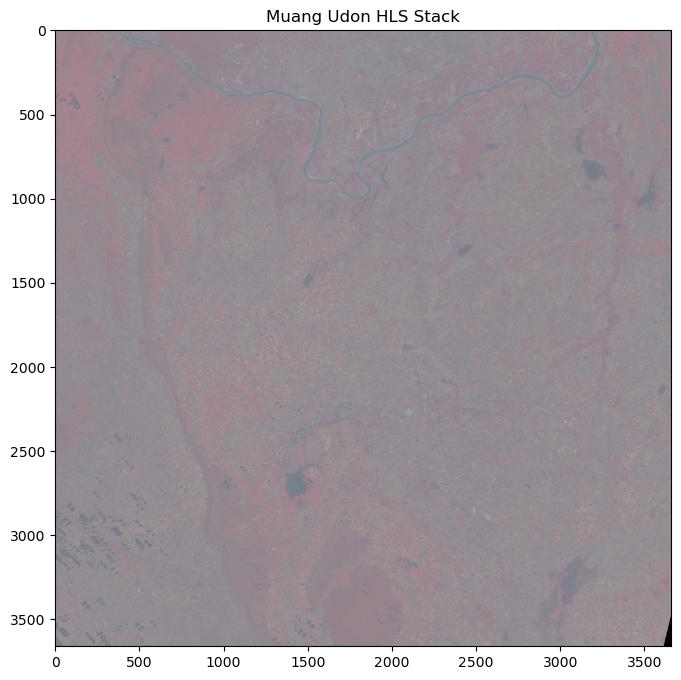

CPU times: user 3.48 s, sys: 729 ms, total: 4.21 s
Wall time: 8.31 s


In [5]:
%%time
# ESTIMATED RUNTIME: <1 minute

#NOTE: the functions in this cell output a raster file for every step of the process, this is done so there is a "checkpoint" for every step
# and the outputs for each process can be reviewed

# --- THESE MODULES ARE USED BY THE CELLS ABOVE, COMMENT OUT IF NOT NECESSSARY TO IMPORT AGAIN ---
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# look for the 6 bands to combine (B | G | R | NIR | SWIR1 | SWIR 2)
def search_bands(img_fname_list, ref_list = ['B02','B03','B04','B8A','B11','B12']):
    fin_list = [fname for fname in img_fname_list if fname.split(".")[-2] in ref_list]
    return fin_list

# ensure that the bands are in order
def order_bands(img_list,bands=['B02','B03','B04','B8A','B11','B12']):
    new_list = img_list[:]
    
    for band in img_list:
        new_id = bands.index(band.split(".")[-2])
        #print(new_id)
        new_list[new_id] = band

    return new_list

# stack images
def stack_images(img_fpath_list,outpath):
    # read metadata of first file
    with rio.open(img_fpath_list[0]) as src0:
        meta = src0.meta
    
    # update meta to reflect the number of layers
    meta.update(count = len(img_fpath_list))

    # read each layer and write it to stack
    with rio.open(outpath, 'w', **meta) as dst:
        for id, layer in enumerate(img_fpath_list, start=1):
            with rio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

# step 1: read the folders with the cloud-masked HLS files
cm_hls_path = 'output/cloudmask' #change the path according to where you stored the cloudmasked data
cm_hls_date_folders = [folder for folder in os.listdir(cm_hls_path)
                    if os.path.isdir(os.path.join(cm_hls_path, folder))
                    and folder != '.ipynb_checkpoints']

# step 2: stack the images
all_img_stack_list = [] #save all images to be stacked

for cm_hls_folder in cm_hls_date_folders:
    
    img_list = [fname for fname in os.listdir(os.path.join(cm_hls_path,cm_hls_folder))
                if fname.split(".")[-1] == 'tif'] #filtering for tif images only
    
    # step 2.1: search for the 6 bands to stack
    fin_img_list = search_bands(img_list)
    fin_img_list = order_bands(fin_img_list)
    #print(fin_img_list)
    
    # step 2.2: get the paths of the images
    fin_img_fpath_list = [os.path.join(os.path.join(cm_hls_path,cm_hls_folder),fname) for fname in fin_img_list]
    print(fin_img_fpath_list)
    all_img_stack_list = all_img_stack_list + fin_img_fpath_list
    
# step 3: stack all images 
out_stack_path = os.path.join('output','muang-udon_HLS_18bands.tif')
stack_images(all_img_stack_list,out_stack_path)
    
# step 4: checking if the new stack images have 18bands and visualizing the raster
with rio.open(out_stack_path) as src:
    data = src.read()
    print("\nImage shape:",data.shape)

    # visualize the HLS file
    rgb = src.read([4,3,2]) # change to [3,2,1] for RGB. [4,3,2] shows False Color
    
    # scale to 0-255 for visualization
    scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

    for i in range(3):
        band = rgb[i]
        min_val = np.min(band[band != 0])
        max_val = np.max(band[band != 0])
        scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)
    
    scaled_rgb_new = scaled_rgb.transpose((1,2,0))

    # display the RGB image
    plt.figure(figsize=(8,8))
    plt.title("Muang Udon HLS Stack")
    plt.imshow(scaled_rgb_new)
    plt.show()

### Step 2: Crop HLS by LU bounds

#### 2.1 Convert LU raster to the same crs as the HLS image

In [41]:
%%time
# ESTIMATED RUNTIME: <1 minute

#NOTE: the functions in this cell output a raster file for every step of the process, this is done so there is a "checkpoint" for every step
# and the outputs for each process can be reviewed

import os
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# -- COMMENT OUT THIS SECTION IF YOU WISH TO USE GDAL FOR REPROJECTION --
# from osgeo import gdal

# def reproject_raster(input_path, output_path, target_crs='EPSG:4326'): 
#     '''target_crs = 4326 by default'''
#     src_ds = gdal.Open(input_path)
#     if not src_ds:
#         raise FileNotFoundError(f"Unable to open {input_path}")

#     # define the target CRS using EPSG code (e.g. 4326 for WGS 84)
#     target_crs_wkt = target_crs

#     # perform the reprojection using gdal.Warp
#     warp_options = gdal.WarpOptions(dstSRS=target_crs_wkt)
#     dst_ds = gdal.Warp(output_path, src_ds, options=warp_options)

#     # flush and close datasets
#     dst_ds.FlushCache()
#     src_ds = None
#     dst_ds = None
# ------------------------------------------------------------------------
      
#hls_stack_path = 'output/muang-udon_HLS_18bands.tif' #change if the directory where the 18-band HLS stack is changed also
#lu_raster_path = '../data/01_preprocessing/muang_udon_lu_raster/LU_muang-udon.tif'
#lu_warped_path = 'output/muang-udon_LU_warped.tif'

hls_stack_path = 'output/khon-kaen_HLS_18bands.tif'
lu_raster_path = '../data/01_preprocessing/muang_udon_lu_raster/khon-kaen.tif'
lu_warped_path = 'output/khon-kaen_LU_warped.tif'
    
# step 1: get the crs of the Stacked HLS image
with rio.open(hls_stack_path) as hls_src:
    hls_crs = hls_src.crs
    hls_transform = hls_src.transform
    # hls_width = hls_src.width
    # hls_height = hls_src.height
    hls_res = hls_src.res
    print("HLS CRS:",hls_crs)
    print("HLS Resolution:",hls_res)
    
# step 2: convert the LU raster into the same crs
with rio.open(lu_raster_path) as lu_src:
    print("Orig LU CRS:",lu_src.crs)
    transform , width, height = calculate_default_transform(
        lu_src.crs,
        hls_crs, #change CRS to HLS CRS
        lu_src.width,
        lu_src.height,
        *lu_src.bounds,
        resolution = hls_res) #change resolution to HLS res
    
    # update the meta for the reprojected raster
    lu_meta = lu_src.meta.copy()
    lu_meta.update({
        'crs':hls_crs,
        'transform':transform,
        'width':width,
        'height':height})

    with rio.open(lu_warped_path, 'w', **lu_meta) as luw_src:
        reproject(
            source=lu_src.read(1), # read the first band
            destination=rio.band(luw_src, 1), # write to the first band of the destination
            src_transform=lu_src.transform,
            src_crs=lu_src.crs,
            dst_transform=transform,
            dst_crs=hls_crs,
            resampling=Resampling.nearest)

HLS CRS: EPSG:32648
HLS Resolution: (30.0, 30.0)
Orig LU CRS: EPSG:4326
CPU times: user 425 ms, sys: 243 ms, total: 668 ms
Wall time: 4.06 s


#### 2.2 Split the LU image into 224 x 224 patches and get corresponding HLS image

In [52]:
%%time
# ESTIMATED RUNTIME: 1-2 minutes, depends on the size of the image

#NOTE: the functions in this cell output a raster file for every step of the process, this is done so there is a "checkpoint" for every step
# and the outputs for each process can be reviewed

import os
import math
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window
from rasterio.mask import mask
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import pandas as pd

lu_warped_path = 'output/khon-kaen_LU_warped.tif'
hls_stack_path = 'output/khon-kaen_HLS_18bands.tif'

# function to get the bounding box of raster image
def get_bbox(img_path):
    with rio.open(img_path) as ref_raster:
        bounds = ref_raster.bounds
        bbox = box(bounds.left,
                   bounds.bottom,
                   bounds.right,
                   bounds.top)

    gdf = gpd.GeoDataFrame({'geometry':bbox},index=[0],crs=ref_raster.crs)

    return gdf

# split image
def split_image(img_path,export_path,outfile_prefix,tile_size=224):
    with rio.open(img_path) as src:
        print("Splitting",img_path)
        print("IMG Shape:",src.shape)
        print("Tile Size:",tile_size)
        
        num_tiles_x = math.ceil(src.width/tile_size)
        num_tiles_y = math.ceil(src.height/tile_size)

        tile_list = []
        print("Num Tiles (x,y):",(num_tiles_x,num_tiles_y))
        
        for y in range(num_tiles_y):
            for x in range(num_tiles_x):
                window = Window(x*tile_size, y*tile_size, tile_size, tile_size)
                transform = rio.windows.transform(window, src.transform)
                tile = src.read(window=window)
    
                # Update metadata for the tile
                profile = src.profile
                profile.update({'height': tile.shape[1],
                                'width': tile.shape[2],
                                'transform': transform})
    
                # Save the tile as a separate image file
                outpath = os.path.join(export_path,outfile_prefix + '_tile-{:02d}-{:02d}.tif'.format(x,y))
                with rio.open(outpath, 'w', **profile) as ds:
                    ds.write(tile)
                    
def crop_resample(img_path, bounds_gdf, output_path, tile_size=224, with_zero=True):
    # open the source raster
    with rio.open(img_path) as src:
        raster_crs = src.crs

        # ensure bounding box has the same crs as source raster
        bounds_gdf = bounds_gdf.to_crs(raster_crs)
        geom = bounds_gdf.geometry
        crop_bounds = tuple(bounds_gdf.geometry.bounds.values[0])
        
        # crop the image
        cropped_image, cropped_transform = mask(src, geom, crop=True, nodata=src.nodata)
        
        # update metadata for cropped image
        cropped_meta = src.meta.copy()
        cropped_meta.update({
            "height": cropped_image.shape[1],
            "width": cropped_image.shape[2],
            "transform": cropped_transform
        })

    # calculate the new shape
    new_height = tile_size
    new_width = tile_size
    
    # define the resampling target array
    resampled_image = np.empty(shape=(src.count, new_height, new_width), dtype=cropped_image.dtype)
    
    # Define the resampling transform
    resampling_transform = rio.transform.from_bounds(
        *crop_bounds,
        new_width,
        new_height
    )
    
    # Perform the resampling
    with rio.open(img_path) as src:
        for i in range(1, src.count + 1):
            rio.warp.reproject(
                source=cropped_image[i-1],
                destination=resampled_image[i-1],
                src_transform=cropped_transform,
                src_crs=src.crs,
                dst_transform=resampling_transform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear
            )
    
    # update metadata for resampled image
    resampled_meta = src.meta.copy()
    resampled_meta.update({
        "height": new_height,
        "width": new_width,
        "transform": resampling_transform
    })
    
    # write the resampled image to the output path
    with rio.open(output_path, 'w', **resampled_meta) as dst:
        dst.write(resampled_image)


# step 1: create output folders for LU and HLS patches
lu_outpath = 'output/patch_images/lu'
hls_outpath = 'output/patch_images/hls'

if not os.path.exists(lu_outpath):
    os.makedirs(lu_outpath)
    print("{} Folder CREATED successfully.".format(lu_outpath))
else:
    print("{} Folder ALREADY EXISTS.".format(lu_outpath))
    
if not os.path.exists(hls_outpath):
    os.makedirs(hls_outpath)
    print("{} Folder CREATED successfully.".format(hls_outpath))
else:
    print("{} Folder ALREADY EXISTS.".format(hls_outpath))

# step 2: split LU into 224 x 224 patches and locate corresponding HLS data
split_image(lu_warped_path,
            lu_outpath,
           'khon-kaen')

lu_patch_list = [fname for fname in os.listdir(lu_outpath) if os.path.splitext(fname)[-1] == '.tif']
#print(lu_patch_list)

# iterate over the list to get the corresponding HLS patches
shape_list = []
vals_list = []
patch_list = []
status_list = []

for lu_patch in lu_patch_list:
    lu_patch_path = os.path.join(lu_outpath,lu_patch)
    #print(lu_patch_path)
    
    lu_patch_bbox = get_bbox(lu_patch_path)
    
    # reading the lu_patch to get shape and values details
    with rio.open(lu_patch_path) as lu_src:
        lu_data = lu_src.read(1)
        
        lu_shape = lu_data.shape
        lu_vals = set(lu_data.flatten())        
        
        patch_list.append(lu_patch)
        shape_list.append(lu_shape)
        vals_list.append(lu_vals)
        
    # remove LU patches that only have blank values
    if len(lu_vals) == 1:
        print("Skipping patch {} due to having only blank values".format(lu_patch))
        print("LU Patch Values:",lu_vals)
        status_list.append("Skipped + Deleted, blank values only")

        os.remove(lu_patch_path)
        continue
    
    # remove LU patches that are non-square
    elif lu_shape != (224,224):
        print("Skipping patch {} due to being NOT square".format(lu_patch))
        print("LU Shape:",lu_shape)
        status_list.append("Skipped + Deleted, NOT square")

        os.remove(lu_patch_path)
        continue

    else:
        #hls will have the same name as lu patch since it is required for the Prithvi model
        crop_resample(hls_stack_path,
                      lu_patch_bbox,
                      os.path.join(hls_outpath,lu_patch))
        
        status_list.append("Corresponding HLS patch generated")
        
        
# generate a CSV log of status and patches
preproc_df = pd.DataFrame({'patch_name':patch_list,
                           'shape':shape_list,
                           'values':vals_list,
                           'status':status_list})
                           
preproc_df.to_csv('output/preprocessing_details.csv')
print("\n>> Preprocessing CSV generated, sample snapshot below.")
print(preproc_df.head(10))

output/patch_images/lu Folder ALREADY EXISTS.
output/patch_images/hls Folder ALREADY EXISTS.
Splitting output/khon-kaen_LU_warped.tif
IMG Shape: (5438, 5177)
Tile Size: 224
Num Tiles (x,y): (24, 25)
Skipping patch khon-kaen_tile-00-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-01-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-02-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-03-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-04-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-05-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-06-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-07-00.tif due to having only blank values
LU Patch Values: {0}
Skipping patch khon-kaen_tile-08-00.tif due to having onl

In [49]:
# IMPORTANT: Only uncomment this cell if you need to cleanse / delete the patch_images folder and generate a new one

# import shutil

# dir_path = 'output/patch_images'
# shutil.rmtree(dir_path)

# print(f"Directory {dir_path} deleted successfully.")

Directory output/patch_images deleted successfully.


#### 2.3 Visualizing the HLS and LU patches for quality assessment


####### HLS #######
Number of HLS Patches: 290
>> Image shape: (18, 224, 224)
CHECK #1: Image shape should be 18,224,224 --> 18 bands, and 224 x 224 pixels.
>> Image CRS: EPSG:32648
CHECK #2: Image should be in the same CRS as the LU patches.
>> Image Resolution: (30.0, 30.0)
CHECK #3: Resolution should be 30m x 30m, represented as (30,30).



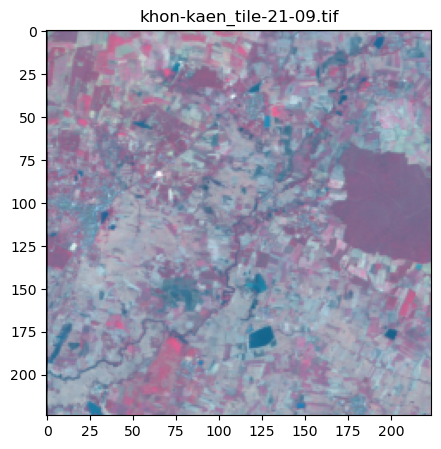


####### LU #######
Number of LU Patches: 290
>> Image shape: (1, 224, 224)
CHECK #1: Image shape should be 1,224,224 --> 1 band, and 224 x 224 pixels.
>> LU Categories: [0, 1, 2, 3, 4, 5, 6]
CHECK #2: There should only be 7 values corresponding to 6 categories + '0' values for null
>> Image CRS: EPSG:32648
CHECK #3: Image should be in the same CRS as the HLS patches.
>> Image Resolution: (30.0, 30.0)
CHECK #4: Resolution should be 30m x 30m, represented as (30,30).



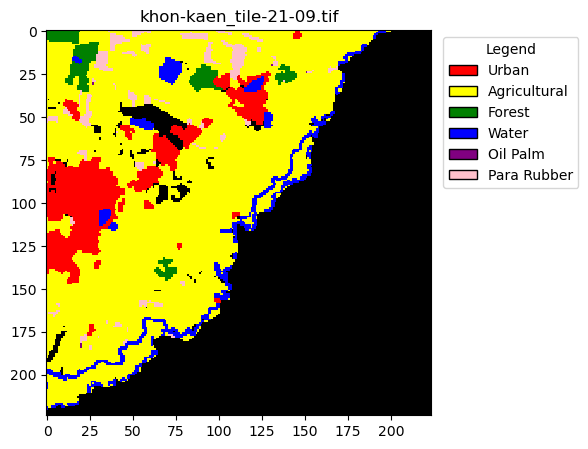

CPU times: user 429 ms, sys: 22.3 ms, total: 451 ms
Wall time: 537 ms


In [53]:
%%time
# Visualizing sample HLS Patch data
# ESTIMATED RUNTIME: <1 minute

import os
import glob
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# lst id of the sample HLS patch to view
sample_id = 153

####### HLS #######
hls_patches_path = 'output/patch_images/hls'
hls_patches_path_list = glob.glob(os.path.join(hls_patches_path, "*.tif"))
print("\n####### HLS #######")
print("Number of HLS Patches:",len(hls_patches_path_list))

# visualizing sample HLS patch
with rio.open(hls_patches_path_list[sample_id]) as src:
    
    fname = os.path.basename(hls_patches_path_list[sample_id]) # get the filename from the path
    data = src.read()
    
    # checking sample image shape, crs, and resolution
    print(">> Image shape:",data.shape)
    print("CHECK #1: Image shape should be 18,224,224 --> 18 bands, and 224 x 224 pixels.")
    print(">> Image CRS:",src.crs)
    print("CHECK #2: Image should be in the same CRS as the LU patches.")
    print(">> Image Resolution:",src.res)
    print("CHECK #3: Resolution should be 30m x 30m, represented as (30,30).")
    print()
    
    # visualize the HLS file
    rgb = src.read([4,3,2]) # change to [3,2,1] for RGB. [4,3,2] shows False Color
    
    # scale to 0-255 for visualization
    scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

    for i in range(3):
        band = rgb[i]
        min_val = np.min(band[band != 0])
        max_val = np.max(band[band != 0])
        scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)
    
    scaled_rgb_new = scaled_rgb.transpose((1,2,0))

    # display the RGB image
    plt.figure(figsize=(5,5))
    plt.title(fname)
    plt.imshow(scaled_rgb_new)
    plt.show()
    
####### LU #######
lu_patches_path = 'output/patch_images/lu'
lu_patches_path_list = glob.glob(os.path.join(lu_patches_path, "*.tif"))
print("\n####### LU #######")
print("Number of LU Patches:",len(lu_patches_path_list))

# visualizing sample LU patch
with rio.open(lu_patches_path_list[sample_id]) as src:
    
    fname = os.path.basename(lu_patches_path_list[sample_id]) # get the filename from the path
    data = src.read(1)
    vals = list(set(data.flatten()))
    
    # checking sample image shape, crs, and resolution
    print(">> Image shape:",src.read().shape)
    print("CHECK #1: Image shape should be 1,224,224 --> 1 band, and 224 x 224 pixels.")
    print(">> LU Categories:",vals)
    print("CHECK #2: There should only be 7 values corresponding to 6 categories + '0' values for null")
    print(">> Image CRS:",src.crs)
    print("CHECK #3: Image should be in the same CRS as the HLS patches.")
    print(">> Image Resolution:",src.res)
    print("CHECK #4: Resolution should be 30m x 30m, represented as (30,30).")
    print()
    
    # set legend color
    value_to_color = {
                        1:'red',
                        2:'yellow',
                        3:'green',
                        4:'blue',
                        5:'purple',
                        6:'pink'}
    
    # create a colormap with these values
    colors = [value_to_color.get(i,'black') for i in range(0,max(value_to_color.keys()) + 1)]
    cmap = ListedColormap(colors)
    
    # display raster with the colormap
    plt.figure(figsize=(5,5))
    plt.title(fname)
    plt.imshow(data,cmap=cmap,interpolation='none')    

    # define the raster value and corresponding land use type
    lu_legend = {1:'Urban',
                 2:'Agricultural',
                 3:'Forest',
                 4:'Water',
                 5:'Oil Palm',
                 6:'Para Rubber'}

    legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                       for value, color in value_to_color.items()]
    plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.4, 1))

    # show the plot
    #plt.tight_layout()
    plt.show()

## REMINDER: Add section to merge cloud-free images for multi-image regions like Khon-Kaen